# Model Experiments

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


Bad key text.latex.preview in file /Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is save

In [14]:
conn = sqlite3.connect('/Users/eerichmo/Documents/fires.sqlite')
cur = conn.cursor()

df_raw = pd.read_sql_query("""
select
	weather_county.fips,
	weather_county.month,
	weather_county.date,
	weather_county.year,
	weather_county.precipitation,
	weather_county.pressure,
	weather_county.humidity_2m,
	weather_county.temp_2m,
	weather_county.temp_dew_point_2m,
	weather_county.temp_wet_bulb_2m,
	weather_county.temp_max_2m,
	weather_county.temp_min_2m,
	weather_county.temp_range_2m,
	weather_county.temp_0m,
	weather_county.wind_10m,
	weather_county.wind_max_10m,
	weather_county.wind_min_10m,
	weather_county.wind_range_10m,
	weather_county.wind_50m,
	weather_county.wind_max_50m,
	weather_county.wind_min_50m,
	weather_county.wind_range_50m,
	weather_county.drought_score,
	soil.elevation,
	soil.slope_005,
	soil.slope_005_02,
	soil.slope_02_05,
	soil.slope_05_10,
	soil.slope_10_15,
	soil.slope_15_30,
	soil.slope_30_45,
	soil.slope_45,
	soil.aspect_north,
	soil.aspect_east,
	soil.aspect_south,
	soil.aspect_west,
	soil.aspect_unknown,
	soil.water_land,
	soil.barren_land,
	soil.urban_land,
	soil.grass_land,
	soil.forest_land,
	soil.partial_cultivated_land,
	soil.irrigated_land,
	soil.cultivated_land,
	soil.nutrient,
	soil.nutrient_retention,
	soil.rooting,
	soil.oxygen,
	soil.excess_salts,
	soil.toxicity,
	soil.workablity,
  ifnull(fires.fire_size_class, '') as fire_size_class
from weather_county
inner join soil
  on soil.fips = weather_county.fips
left outer join (
select max(fire_size_class) as fire_size_class, fips, date
	from (
		-- Join date and 1, 2 and 3 days earlier in case the discovery date is delayed
		select fire_size_class, fips, date from fires
		where cause_descr in ('Miscellaneous', 'Lightning', 'Powerline', 'Missing/Undefined', 'Debris Buring', 'Campfire')
		union
		select fire_size_class, fips, date_1d_before as date from fires
		where cause_descr in ('Miscellaneous', 'Lightning', 'Powerline', 'Missing/Undefined', 'Debris Buring', 'Campfire')
		union
		select fire_size_class, fips, date_2d_before as date from fires
		where cause_descr in ('Miscellaneous', 'Lightning', 'Powerline', 'Missing/Undefined', 'Debris Buring', 'Campfire')
		union
		select fire_size_class, fips, date_3d_before as date from fires
		where cause_descr in ('Miscellaneous', 'Lightning', 'Powerline', 'Missing/Undefined', 'Debris Buring', 'Campfire')
	)
	group by fips, date
) as fires on
  fires.fips = weather_county.fips
  and fires.date = weather_county.date
where
	weather_county.fips != 6065
	and weather_county.year in (2005, 2006, 2007, 2008)
""", conn)

# Ignoring FIPS = 6065, Riverside, since it has a disproportionate number of 'Miscellaneous' fires 

conn.close()

df_raw.date = pd.to_datetime(df_raw.date)
df_raw['day_of_week'] = df_raw.date.dt.dayofweek

df_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fips,83277.0,6057.877193,33.761007,6001.00,6029.000000,6057.000000,6087.000000,6115.000000
month,83277.0,6.522930,3.448724,1.00,4.000000,7.000000,10.000000,12.000000
year,83277.0,2006.501027,1.118346,2005.00,2006.000000,2007.000000,2008.000000,2008.000000
precipitation,83277.0,1.684698,5.544391,0.00,0.000000,0.010000,0.330000,104.520000
pressure,83277.0,94.069435,6.086902,73.90,91.020000,96.000000,98.980000,103.240000
humidity_2m,83277.0,5.779621,1.963660,0.64,4.340000,5.720000,7.150000,17.940000
temp_2m,83277.0,13.879346,8.070981,-16.26,8.310000,13.470000,19.720000,41.390000
temp_dew_point_2m,83277.0,3.944862,5.720350,-23.10,0.280000,4.680000,8.270000,23.010000
temp_wet_bulb_2m,83277.0,3.997204,5.645449,-21.63,0.340000,4.700000,8.270000,23.010000
temp_max_2m,83277.0,20.827836,9.850577,-13.80,13.530000,20.140000,28.400000,49.910000


In [15]:
df_fire_false = df_raw[df_raw.fire_size_class == '']
df_fire_true = df_raw[df_raw.fire_size_class != '']
print(f'Unbalanced classes of NO fire: {len(df_fire_false):,} and YES fire: {len(df_fire_true):,}')

df_fire_true_balanced = df_fire_true.sample(n=len(df_fire_false), replace=True)

df_fires = pd.concat([df_fire_false, df_fire_true_balanced], axis=0)
df_fire_false = df_fires[df_fires.fire_size_class == '']
df_fire_true = df_fires[df_fires.fire_size_class != '']
print(f'Balanced classes of NO fires: {len(df_fire_false):,} and YES fire: {len(df_fire_true):,}')

X_trim = df_fires.drop(['date', 'fire_size_class'], axis=1)

Unbalanced classes of NO fire: 58,212 and YES fire: 25,065
Balanced classes of NO fires: 58,212 and YES fire: 58,212


<AxesSubplot:>

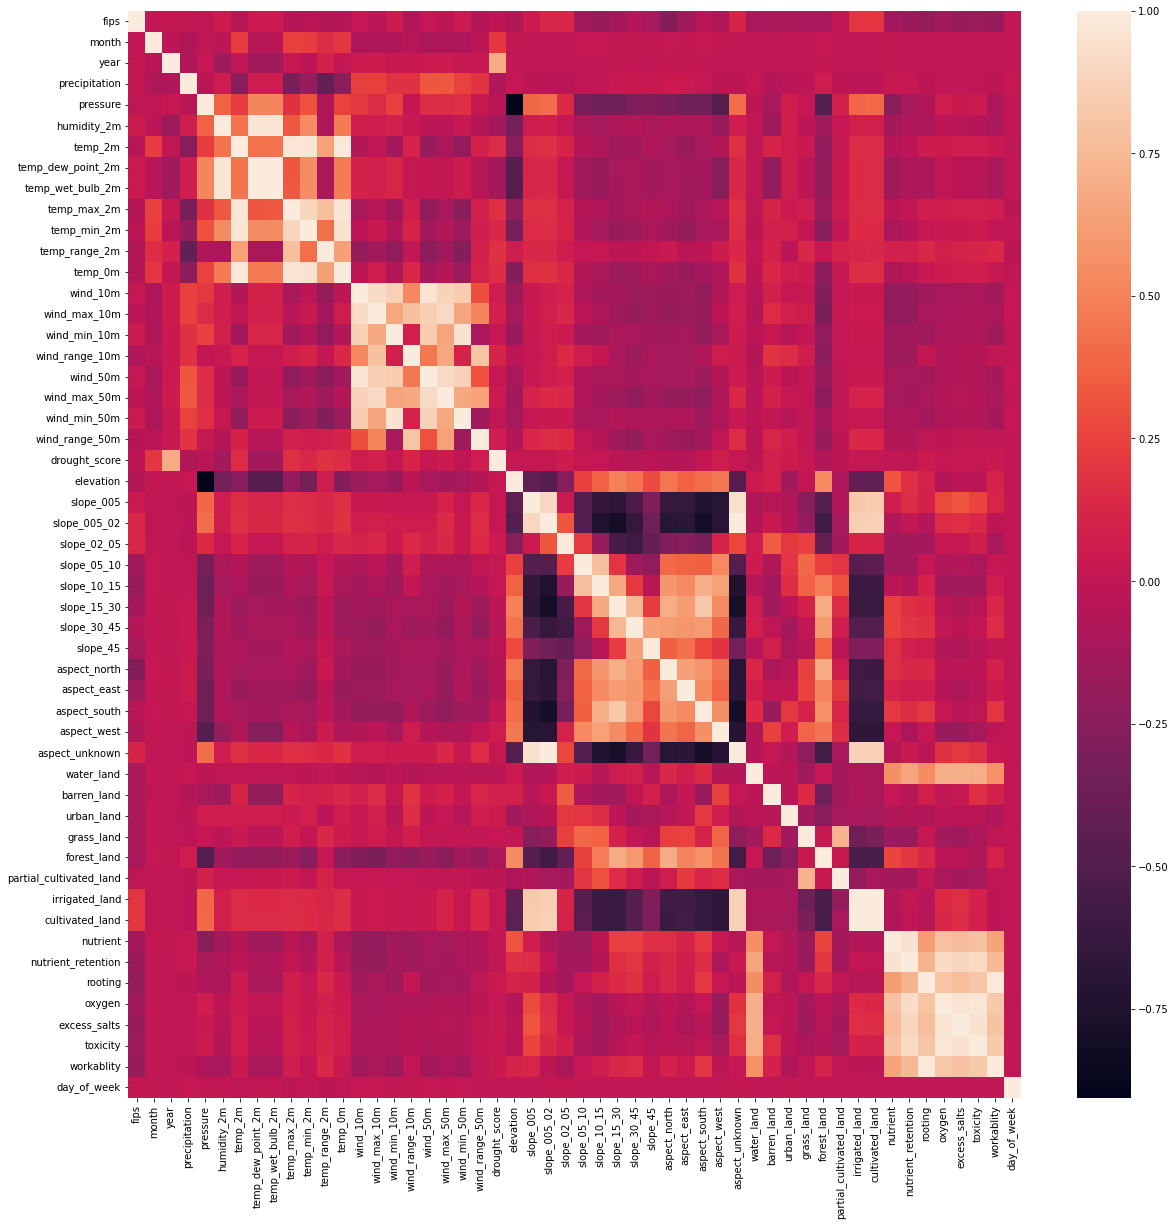

In [16]:
plt.figure(figsize=(20, 20))
sns.heatmap(X_trim.corr())

In [17]:
X_encoded = pd.get_dummies(X_trim, columns=['fips', 'day_of_week', 'year', 'month'])

scaler = StandardScaler()
scaler.fit(X_encoded)
X = scaler.transform(X_encoded)

### All Fire Sizes (A-G)

In [18]:
y = (df_fires.fire_size_class != '').values

num_fires = (y == 1).sum()
num_data_pt = len(y)
print(f'{num_fires} fires out of {len(y)} data points')
print(f'No fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie Balanced)')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

params={
  'C': [0.1, 1, 2],
}

log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg = GridSearchCV(estimator=log_reg, param_grid=params, scoring='recall', cv=5)

log_reg.fit(X_train, y_train)

print(f'All size fires estimator', log_reg.best_estimator_)

58212 fires out of 116424 data points
No fires 50.0% of the time (ie Balanced)
All size fires estimator LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')


In [19]:
print('--------- Log Regression Accuracy ---------')
print(accuracy_score(log_reg.predict(X_test), y_test))

y_pred_log_reg = log_reg.predict(X_train)

print('--------- Log Regression Classification ---------')
print(classification_report(y_train, y_pred_log_reg))

--------- Log Regression Accuracy ---------
0.7907304335875764
--------- Log Regression Classification ---------
              precision    recall  f1-score   support

       False       0.80      0.78      0.79     43538
        True       0.79      0.81      0.80     43780

    accuracy                           0.79     87318
   macro avg       0.79      0.79      0.79     87318
weighted avg       0.79      0.79      0.79     87318



In [29]:
from sklearn.ensemble import RandomForestClassifier

params = {
  'n_estimators': np.arange(40, 100, 20),
  # 'splitter': ['best', 'random'],
  'max_features': np.arange(4, 12, 1),
  'max_depth': np.arange(10, 20, 2),
  'min_samples_split': np.arange(4, 12, 2),
  'min_samples_leaf': np.arange(2, 10, 2),
  'max_leaf_nodes': np.arange(4, 10, 2),
}

rand_forest = RandomizedSearchCV(RandomForestClassifier(), params, scoring="recall")
rand_forest.fit(X_train, y_train)

print(f'Best Params', rand_forest.best_params_)
print(f'Best Score', rand_forest.best_score_)

print('--------- RandomForestClassifier Classification ---------')
y_pred_rand_forest = rand_forest.predict(X_test)
print(classification_report(y_test, y_pred_rand_forest))

Best Params {'n_estimators': 40, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_leaf_nodes': 4, 'max_features': 4, 'max_depth': 10}
Best Score 0.723184102329831
--------- RandomForestClassifier Classification ---------
              precision    recall  f1-score   support

       False       0.73      0.73      0.73     14674
        True       0.72      0.72      0.72     14432

    accuracy                           0.72     29106
   macro avg       0.72      0.72      0.72     29106
weighted avg       0.72      0.72      0.72     29106



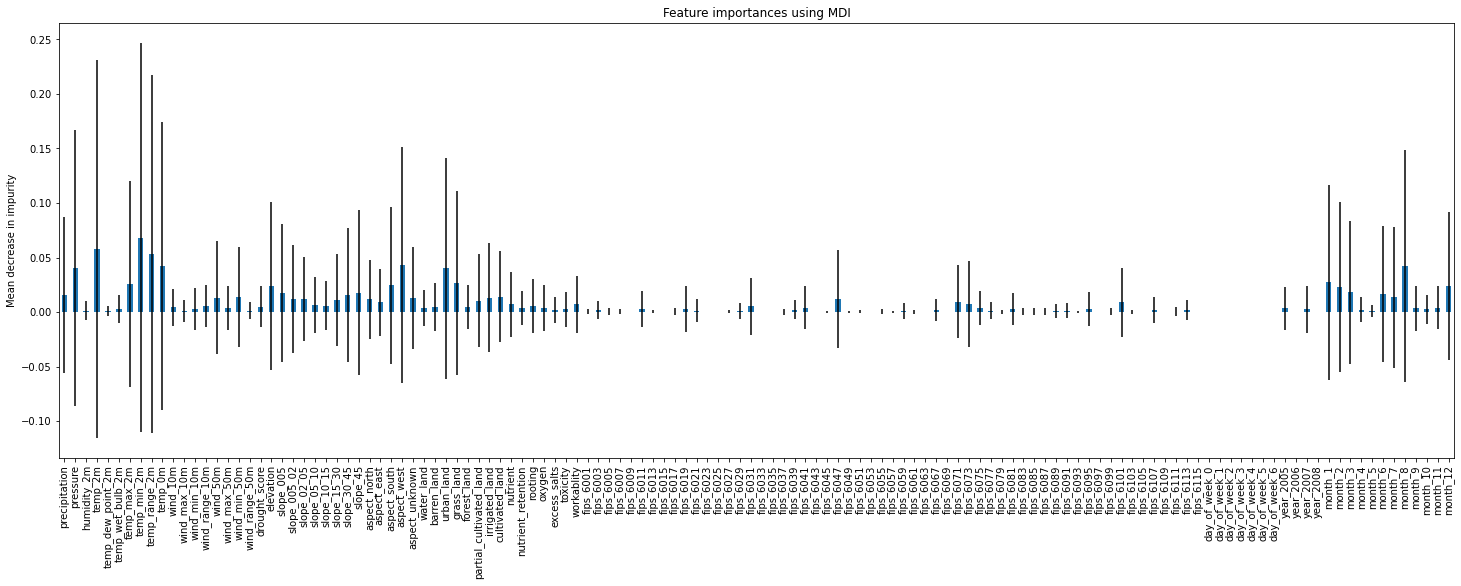

In [21]:
importances = rand_forest.best_estimator_.feature_importances_
forest_importances = pd.Series(importances, index=X_encoded.columns.values)
std = np.std([tree.feature_importances_ for tree in rand_forest.best_estimator_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.set_figheight(8)
fig.set_figwidth(25)

In [22]:
import xgboost as xgb

params={
  'objective': ['binary:logistic'],
  'max_depth': [4, 5, 6, 7],
  'gamma':[0.1, 0.5, 1],
  'subsample': [0.5],
  'colsample_bytree': [0.1],
  'colsample_bylevel': [1.0],
  'learning_rate': [0.1, 0.5],
  'n_estimators': [500, 600, 700],
  'eval_metric': ['logloss']
}

xgb_clf = xgb.XGBClassifier(seed=42, use_label_encoder=False)

xgb_clf = RandomizedSearchCV(estimator=xgb_clf, param_distributions=params)

xgb_clf.fit(X_train, y_train)

print("Best Params:", xgb_clf.best_params_)


Best Params: {'subsample': 0.5, 'objective': 'binary:logistic', 'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'eval_metric': 'logloss', 'colsample_bytree': 0.1, 'colsample_bylevel': 1.0}


In [23]:
y_pred_xgb = xgb_clf.predict(X_test)

print('--------- XGBoost Classification Report ---------')
print(classification_report(y_test, y_pred_xgb))

--------- XGBoost Classification Report ---------
              precision    recall  f1-score   support

       False       0.84      0.81      0.83     14674
        True       0.82      0.85      0.83     14432

    accuracy                           0.83     29106
   macro avg       0.83      0.83      0.83     29106
weighted avg       0.83      0.83      0.83     29106



### Only Larger Fire Sizes (B-G)

In [24]:
df_non_small_false = df_raw[df_raw.fire_size_class <= 'A']
df_non_small_true = df_raw[df_raw.fire_size_class > 'A']
print(f'Unbalanced classes of NO fire: {len(df_non_small_false):,} and YES fire: {len(df_non_small_true):,}')

df_non_small_true_balanced = df_non_small_true.sample(n=len(df_non_small_false), replace=True)

df_non_small = pd.concat([df_non_small_false, df_non_small_true_balanced], axis=0)
df_non_small_false = df_non_small[df_non_small.fire_size_class <= 'A']
df_non_small_true = df_non_small[df_non_small.fire_size_class > 'A']
print(f'Balanced classes of NO fires: {len(df_non_small_false):,} and YES fire: {len(df_non_small_true):,}')

X_non_small_trim = df_non_small.drop(['date', 'fire_size_class'], axis=1)

X_non_small_encoded = pd.get_dummies(X_non_small_trim, columns=['fips', 'day_of_week', 'year', 'month'])

scaler = StandardScaler()
scaler.fit(X_non_small_encoded)
X_non_small = scaler.transform(X_non_small_encoded)

Unbalanced classes of NO fire: 66,694 and YES fire: 16,583
Balanced classes of NO fires: 66,694 and YES fire: 66,694


In [25]:
y_non_small = (df_non_small.fire_size_class > 'A').values # Ignore small fires ('' or 'A') for now

X_non_small_train, X_non_small_test, y_non_small_train, y_non_small_test = train_test_split(X_non_small, y_non_small, random_state=42)

params={
  'C': [0.1, 1, 2],
}

log_reg_non_small = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg_non_small = GridSearchCV(estimator=log_reg_non_small, param_grid=params, scoring='recall', cv=5)

log_reg_non_small.fit(X_non_small_train, y_non_small_train)

print(f'Non-small fires estimator', log_reg_non_small.best_estimator_)

Non-small fires estimator LogisticRegression(C=1, max_iter=1000, solver='liblinear')


In [26]:
print('--------- Log Regression Accuracy (non-small fires) ---------')
print(accuracy_score(log_reg_non_small.predict(X_non_small_test), y_non_small_test))

y_non_small_pred_log_reg = log_reg_non_small.predict(X_non_small_train)

print('--------- Log Regression Classification (non-small fires) ---------')
print(classification_report(y_non_small_train, y_non_small_pred_log_reg))

--------- Log Regression Accuracy (non-small fires) ---------
0.7936546016133386
--------- Log Regression Classification (non-small fires) ---------
              precision    recall  f1-score   support

       False       0.80      0.77      0.79     50017
        True       0.78      0.81      0.80     50024

    accuracy                           0.79    100041
   macro avg       0.79      0.79      0.79    100041
weighted avg       0.79      0.79      0.79    100041



In [27]:
import xgboost as xgb

params={
  'objective': ['binary:logistic'],
  'max_depth': [3],
  'gamma':[5],
  'subsample': [0.5],
  'colsample_bytree': [0.1],
  'colsample_bylevel': [1.0],
  'learning_rate': [0.1],
  'n_estimators': [500],
  'eval_metric': ['logloss']
}

xgb_clf_non_small = xgb.XGBClassifier(seed=42, use_label_encoder=False)

xgb_clf_non_small = RandomizedSearchCV(estimator=xgb_clf_non_small, param_distributions=params)

xgb_clf_non_small.fit(X_non_small_train, y_non_small_train)

print("Non-small best Params:", xgb_clf_non_small.best_params_)

/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Non-small best Params: {'subsample': 0.5, 'objective': 'binary:logistic', 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 5, 'eval_metric': 'logloss', 'colsample_bytree': 0.1, 'colsample_bylevel': 1.0}


In [28]:
y_non_small_pred_xgb = xgb_clf_non_small.predict(X_non_small_test)

print('--------- XGBoost Classification Report (non-small) ---------')
print(classification_report(y_non_small_test, y_non_small_pred_xgb))

--------- XGBoost Classification Report (non-small) ---------
              precision    recall  f1-score   support

       False       0.83      0.78      0.80     16677
        True       0.79      0.84      0.81     16670

    accuracy                           0.81     33347
   macro avg       0.81      0.81      0.81     33347
weighted avg       0.81      0.81      0.81     33347

